In [0]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.utils import AnalysisException

# Create a SparkSession
spark = SparkSession.builder.appName("MyApp").getOrCreate()

# Define the URL to the CSV file
csv_url = "https://github.com/selva86/datasets/raw/master/Admission.csv"

try:
    # Read data into a Pandas DataFrame
    pandas_df = pd.read_csv(csv_url)

     # Sanitize column names to adhere to Spark's requirements
    pandas_df.columns = [col.replace(" ", "_").replace(".", "_").replace("(", "_").replace(")", "_") for col in pandas_df.columns]

    # Convert Pandas DataFrame to Spark DataFrame
    spark_df = spark.createDataFrame(pandas_df)

    # Display the schema of the source data
    spark_df.printSchema()

    # Define the Delta table path
    delta_path = "/delta/admission_data"

    # Write the DataFrame as a Delta table
    spark_df.write.format("delta").mode("overwrite").save(delta_path)

    print("Data loaded into Delta table successfully.")

except AnalysisException as e:
    # Handle AnalysisException (e.g., if the specified Delta table doesn't exist)
    print("Error: AnalysisException -", e)

except Exception as e:
    # Handle other exceptions
    print("Unexpected error:", e)

# finally:
#     # Stop the Spark session
#     spark.stop()


root
 |-- Serial_No_: long (nullable = true)
 |-- GRE_Score: long (nullable = true)
 |-- TOEFL_Score: long (nullable = true)
 |-- University_Rating: long (nullable = true)
 |-- SOP: double (nullable = true)
 |-- LOR_: double (nullable = true)
 |-- CGPA: double (nullable = true)
 |-- Research: long (nullable = true)
 |-- Chance_of_Admit_: double (nullable = true)

Data loaded into Delta table successfully.


In [0]:
# Perform data transformations using Spark SQL
try:
    spark_df.createOrReplaceTempView("admissions_data")

    transformed_data = spark.sql("""
        SELECT Serial_No_,
               GRE_Score,
               TOEFL_Score,
               University_Rating,
               SOP,
               LOR_,
               CGPA,
               Research,
               Chance_of_Admit_ as Admission_Chance,
               -- Calculate total score: Example transformation
               (GRE_Score + TOEFL_Score + CGPA) as Total_Score,
               -- Add more transformations as needed
               -- Example: Normalize CGPA to a scale of 0 to 1
               (CGPA - (SELECT MIN(CGPA) FROM admissions_data)) / 
                   (SELECT MAX(CGPA) - MIN(CGPA) FROM admissions_data) as Normalized_CGPA
        FROM admissions_data
    """)

    print("Transformations completed successfully.")

except AnalysisException as e:
    print(f"Error: AnalysisException - {e}")

except Exception as e:
    print(f"Unexpected error: {e}")


Transformations completed successfully.


In [0]:
transformed_data.show(10)

+----------+---------+-----------+-----------------+---+----+----+--------+----------------+-----------+-------------------+
|Serial_No_|GRE_Score|TOEFL_Score|University_Rating|SOP|LOR_|CGPA|Research|Admission_Chance|Total_Score|    Normalized_CGPA|
+----------+---------+-----------+-----------------+---+----+----+--------+----------------+-----------+-------------------+
|         1|      337|        118|                4|4.5| 4.5|9.65|       1|            0.92|     464.65| 0.9134615384615385|
|         2|      324|        107|                4|4.0| 4.5|8.87|       1|            0.76|     439.87| 0.6634615384615382|
|         3|      316|        104|                3|3.0| 3.5| 8.0|       1|            0.72|      428.0|0.38461538461538464|
|         4|      322|        110|                3|3.5| 2.5|8.67|       1|             0.8|     440.67| 0.5993589743589743|
|         5|      314|        103|                2|2.0| 3.0|8.21|       0|            0.65|     425.21|0.45192307692307726|


In [0]:
# Define the Delta table path
delta_path = "/delta/admissions_data"

# Define the table name in the Databricks catalog
table_name_in_catalog = "admissions_catalog_table"

try:
    # Write the transformed data to the Databricks catalog
    transformed_data.write.option("mergeSchema", "true").mode('overwrite').saveAsTable('default.admissions_catalog_table')

    # Display the first 10 rows of the transformed data
    transformed_data.show(10)

except AnalysisException as e:
    print(f"Error: AnalysisException - {e}")

except Exception as e:
    print(f"Unexpected error: {e}")


+----------+---------+-----------+-----------------+---+----+----+--------+----------------+-----------+-------------------+
|Serial_No_|GRE_Score|TOEFL_Score|University_Rating|SOP|LOR_|CGPA|Research|Admission_Chance|Total_Score|    Normalized_CGPA|
+----------+---------+-----------+-----------------+---+----+----+--------+----------------+-----------+-------------------+
|         1|      337|        118|                4|4.5| 4.5|9.65|       1|            0.92|     464.65| 0.9134615384615385|
|         2|      324|        107|                4|4.0| 4.5|8.87|       1|            0.76|     439.87| 0.6634615384615382|
|         3|      316|        104|                3|3.0| 3.5| 8.0|       1|            0.72|      428.0|0.38461538461538464|
|         4|      322|        110|                3|3.5| 2.5|8.67|       1|             0.8|     440.67| 0.5993589743589743|
|         5|      314|        103|                2|2.0| 3.0|8.21|       0|            0.65|     425.21|0.45192307692307726|


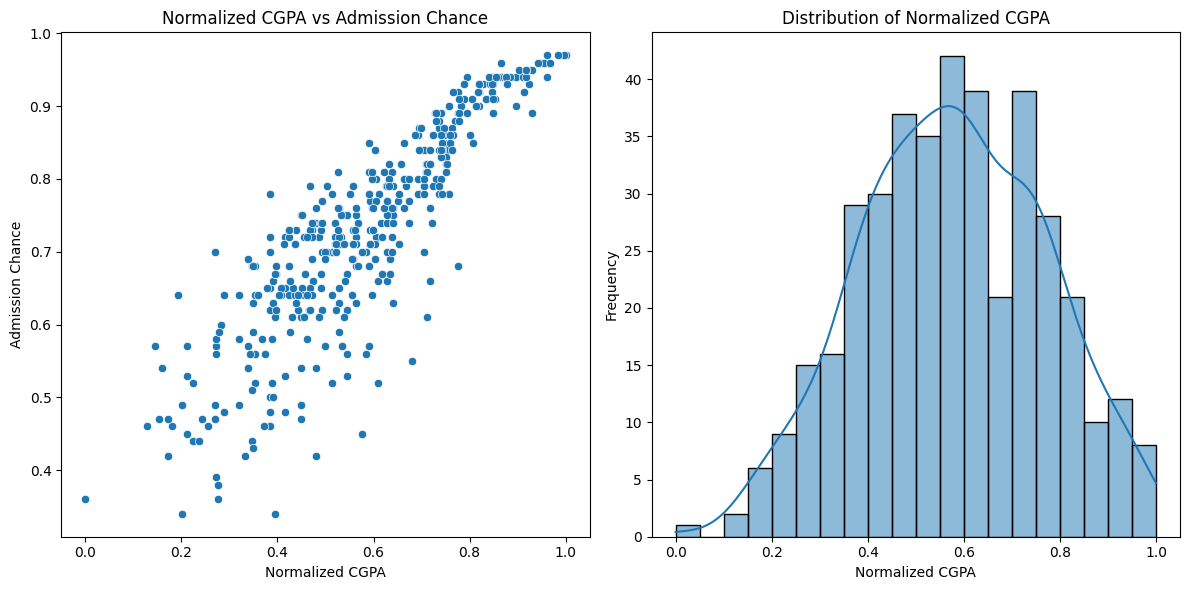

In [0]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Enable inline plotting in Databricks
%matplotlib inline

# Plotting
plt.figure(figsize=(12, 6))

# Scatter plot for Normalized_CGPA vs Admission_Chance
plt.subplot(1, 2, 1)
sns.scatterplot(x='Normalized_CGPA', y='Admission_Chance', data=transformed_data.toPandas())
plt.title('Normalized CGPA vs Admission Chance')
plt.xlabel('Normalized CGPA')
plt.ylabel('Admission Chance')

# Histogram for Normalized_CGPA
plt.subplot(1, 2, 2)
sns.histplot(transformed_data.toPandas()['Normalized_CGPA'], bins=20, kde=True)
plt.title('Distribution of Normalized CGPA')
plt.xlabel('Normalized CGPA')
plt.ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()
